# Coding Challenge #1 - Meteogram Plot
In this exercise, you'll gain familiarity with some Python basics by producing a meteogram. We will plot 5-minute weather observations from KPHL on a day where multiple rounds of severe thunderstorms impacted southeast PA.  
This tutorial uses three powerful python modules that are commonly used when working with weather data: matplotlib, and pandas. The documentation can be helpful, in addition to google searches.  
https://pandas.pydata.org/docs/  
https://matplotlib.org/stable/contents.html  

First, import the python librairies necessary. Think of these as "add-ons" to Python's basic functionality. The imported library names (pd, plt) are now python objects.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

First, we'll read data from the csv file. You can open the csv in JupyterHub with right click->open with->CSVTable to look at the data first.  
Using the pandas read_csv function, we can easily read data from the csv into a pandas dataframe (we will call it df). https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

In [2]:
# Here's what it looks like
pd.read_csv('./data/KPHL.csv') # specify the file path as a "relative" path

,time,temp_f,dew_f,wind_speed_kt,wind_gust_kt,wind_dir_deg,slp_mb,cloud_total_pct,precip_1hr_in
0,2020-06-03 00:00:00,71.60,46.40,5.0,NaN,230.0,NaN,100.0,NaN
1,2020-06-03 00:05:00,71.60,46.40,7.0,NaN,230.0,NaN,100.0,NaN
2,2020-06-03 00:10:00,69.80,46.40,8.0,NaN,230.0,NaN,100.0,NaN
3,2020-06-03 00:15:00,71.60,46.40,7.0,NaN,230.0,NaN,100.0,NaN
4,2020-06-03 00:20:00,69.80,46.40,8.0,NaN,230.0,NaN,100.0,NaN
...,...,...,...,...,...,...,...,...,...
316,2020-06-03 23:45:00,64.94,64.04,11.0,35.0,360.0,NaN,100.0,0.45
317,2020-06-03 23:50:00,66.20,64.40,11.0,NaN,340.0,NaN,75.0,NaN
318,2020-06-03 23:54:00,68.00,64.94,11.0,NaN,360.0,1005.0,100.0,0.51
319,2020-06-03 23:55:00,66.20,64.40,11.0,NaN,360.0,NaN,100.0,NaN


Checking this against the csv file, it looks like our data has been read correctly!  
You'll notice that the index column (bold) is numbered according to the row numbers in the csv. This is fine, but with timeseries data, it sometimes makes sense to make the time column our index column. Additionally, we need to make sure our timestamps are treated as datetime objects, not strings. Here's a couple of more tricks with the dataframe to make our lives a bit easier:

In [3]:
df = pd.read_csv('./data/KPHL.csv', parse_dates=['time']) # pass an argument to tell pandas to treat the time column as datetime
df = df.set_index('time') # for timeseries, it's often useful to set the timestamp as the "index" column in pandas
df

,temp_f,dew_f,wind_speed_kt,wind_gust_kt,wind_dir_deg,slp_mb,cloud_total_pct,precip_1hr_in
time,,,,,,,,
2020-06-03 00:00:00,71.60,46.40,5.0,NaN,230.0,NaN,100.0,NaN
2020-06-03 00:05:00,71.60,46.40,7.0,NaN,230.0,NaN,100.0,NaN
2020-06-03 00:10:00,69.80,46.40,8.0,NaN,230.0,NaN,100.0,NaN
2020-06-03 00:15:00,71.60,46.40,7.0,NaN,230.0,NaN,100.0,NaN
2020-06-03 00:20:00,69.80,46.40,8.0,NaN,230.0,NaN,100.0,NaN
...,...,...,...,...,...,...,...,...
2020-06-03 23:45:00,64.94,64.04,11.0,35.0,360.0,NaN,100.0,0.45
2020-06-03 23:50:00,66.20,64.40,11.0,NaN,340.0,NaN,75.0,NaN
2020-06-03 23:54:00,68.00,64.94,11.0,NaN,360.0,1005.0,100.0,0.51


We'll need to extract some data to be able to make plots. Here's a few examples of indexing and selecting data from our pandas dataframe:

In [4]:
# The temperature timeseries - this is a pandas dataarray
df['temp_f'] # using the column name (key) to select the data we want

time
2020-06-03 00:00:00    71.60
2020-06-03 00:05:00    71.60
2020-06-03 00:10:00    69.80
2020-06-03 00:15:00    71.60
2020-06-03 00:20:00    69.80
                       ...  
2020-06-03 23:45:00    64.94
2020-06-03 23:50:00    66.20
2020-06-03 23:54:00    68.00
2020-06-03 23:55:00    66.20
2020-06-04 00:00:00    68.00
Name: temp_f, Length: 321, dtype: float64

In [5]:
# Get the raw values as an array using the .values attribute
df['temp_f'].values # this is what we want to plot

array([71.6 , 71.6 , 69.8 , 71.6 , 69.8 , 71.6 , 69.8 , 69.8 , 69.8 ,
       69.8 , 69.8 , 69.08, 69.8 , 69.8 , 69.8 , 69.8 , 69.8 , 69.8 ,
       69.8 , 69.8 , 69.8 , 69.8 , 69.8 , 69.8 , 69.08, 69.8 , 68.  ,
       69.8 , 69.8 , 69.8 , 68.  , 68.  , 68.  , 68.  , 68.  , 69.8 ,
       68.  , 68.  , 68.  , 69.8 , 69.8 , 68.  , 68.  , 68.  , 68.  ,
       66.2 , 66.2 , 66.2 , 66.2 , 66.2 , 66.02, 66.2 , 66.2 , 66.2 ,
       66.2 , 66.2 , 66.2 , 66.2 , 66.2 , 66.2 , 66.2 , 66.2 , 66.2 ,
       66.02, 66.2 , 66.2 , 66.2 , 66.2 , 66.2 , 66.2 , 66.2 , 66.2 ,
       66.2 , 66.2 , 66.2 , 66.2 , 66.02, 66.2 , 66.2 , 66.2 , 66.2 ,
       66.2 , 66.2 , 66.2 , 66.2 , 66.2 , 66.2 , 66.2 , 66.2 , 66.02,
       66.2 , 66.2 , 66.2 , 66.2 , 66.2 , 66.2 , 66.2 , 66.2 , 66.2 ,
       66.2 , 66.2 , 66.2 , 66.92, 66.2 , 66.2 , 66.2 , 66.2 , 66.2 ,
       66.2 , 68.  , 66.2 , 68.  , 68.  , 68.  , 68.  , 68.  , 68.  ,
       68.  , 68.  , 68.  , 68.  , 68.  , 68.  , 68.  , 69.8 , 69.8 ,
       68.  , 68.  ,

In [6]:
# The timestamps - access via the dataframe's index attribute
df.index.values[0:10] # only the first 10 values as an example

array(['2020-06-03T00:00:00.000000000', '2020-06-03T00:05:00.000000000',
       '2020-06-03T00:10:00.000000000', '2020-06-03T00:15:00.000000000',
       '2020-06-03T00:20:00.000000000', '2020-06-03T00:25:00.000000000',
       '2020-06-03T00:30:00.000000000', '2020-06-03T00:35:00.000000000',
       '2020-06-03T00:40:00.000000000', '2020-06-03T00:45:00.000000000'],
      dtype='datetime64[ns]')

### Plotting

We're now ready to plot some data. We'll use Python's matplotlib plotting library to create a highly customizable plot.  

First, we'll set up the figure window where the axes will be drawn. The figure size is specified in inches, and I usually like to use a large size to make sure the plot is high-resolution. You can also specify resolution in dpi (dots per inch). https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html  

Next, place an axes inside the figure window. Since we want the plot to fill the entire figure window, we'll add a single subplot with ```fig.add_subplot(nrows,ncols,index)```. Since it's a single plot, there will be 1 row, 1 column, and the plot index is 1. This can also be specified as an integer (111). https://matplotlib.org/stable/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure.add_subplot  

The next step is to create a simple line plot of temperature using the ```ax.plot()``` function. I'll use a linewidth and color appropriate for temperature. https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html

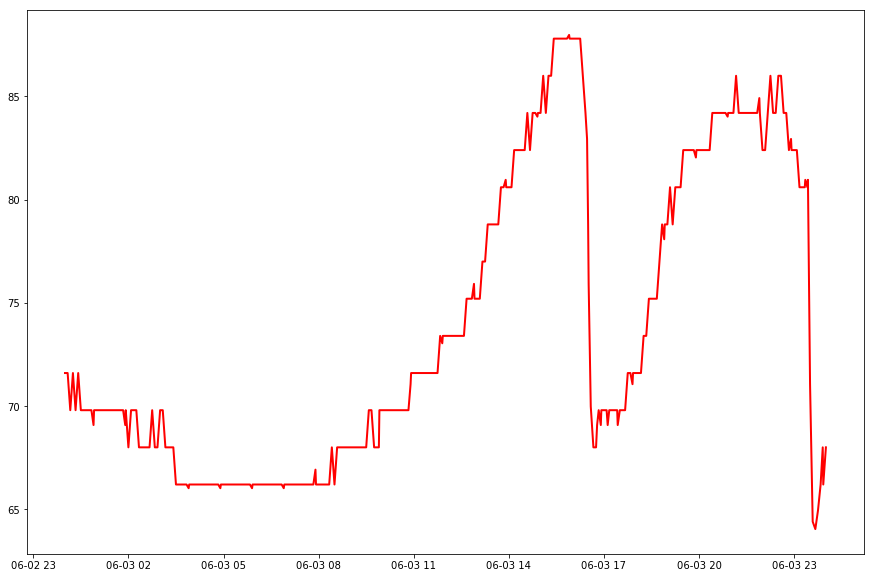

In [7]:
# Setting up the matplotlib figure
fig = plt.figure(figsize=(15,10)) # this creates a figure object - the figure size is specified in inches
ax = fig.add_subplot(1,1,1) # creating a single axes that fills the whole figure window

# Plot temperatures
ax.plot(df.index.values, df['temp_f'].values, color='red', linewidth=2)

# Show the plot (not necessary in JupyterLab, but you must tell Python to show the plot if running a script from the terminal)
plt.show()

Looks good - let's take this plot to the next level!  

Since most of the observations are taken to the nearest degree celsius (only hourlies are not rounded), the lines are not very appealing to look at. I smooth the line by plotting a running mean of temepratures using ```pandas.dataframe.rolling()```. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html  

We want to plot several weather variables on the same plot. Since dew point and temperature are most often in the same range, it makes sense to plot them on the same axes.  

However, a quantity like wind speed may not be in the same range as temperature and dew point. We'll make a second axes in the same subplot to plot the wind speed.

Text(0,1,'A nicer-looking meteogram')

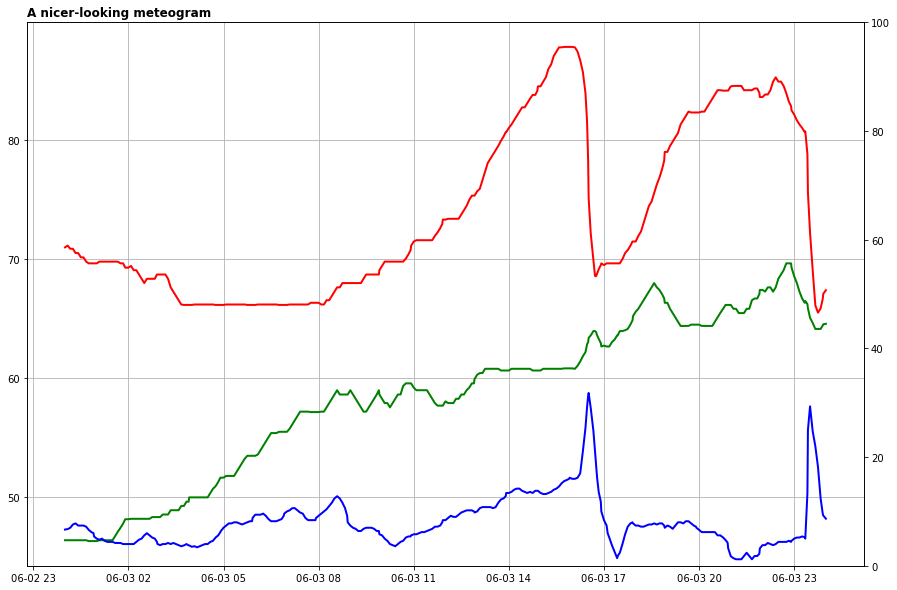

In [8]:
# Setting up the matplotlib figure
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

# Plot temperatures
smoothed = df['temp_f'].rolling(5, center=True, min_periods=1).mean() # See pandas documentation for more about this
# I set size of rolling window based on what looks good without losing too much information
p1 = ax.plot(df.index.values, smoothed.values, color='red', linewidth=2, label='Temperature (F)') # get handle for legend

# Plot dew point
p2 = ax.plot(df.index.values, df['dew_f'].rolling(5, center=True, min_periods=1).mean().values,
             color='green', linewidth=2, label='Dew Point (F)')

# Add grid lines
ax.grid()

# Create a second axes and plot wind speed
ax2 = ax.twinx() # make a "twin" axes within the same subplot; the axis labels will appear on the opposite side
ax2.set_ylim(0,100) # fix y range so wind speed line does not interfere with temp and dew point
p2 = ax2.plot(df.index.values, df['wind_speed_kt'].rolling(5, center=True, min_periods=1).mean().values,
             color='blue', linewidth=2, label='Wind Speed (kt)')
# A title
plt.title('A nicer-looking meteogram', fontweight='bold', loc='left')

This meteogram is starting to look even better, but we haven't added all of the variables yet. As you can imagine, it could get quite cluttered if we plot all of the data in a single subplot. To prevent clutter, it can be useful to use subplots. Here's an example of a simple 2-panel subplot layout you can use.

Text(0.5,1,'2-panel meteogram layout')

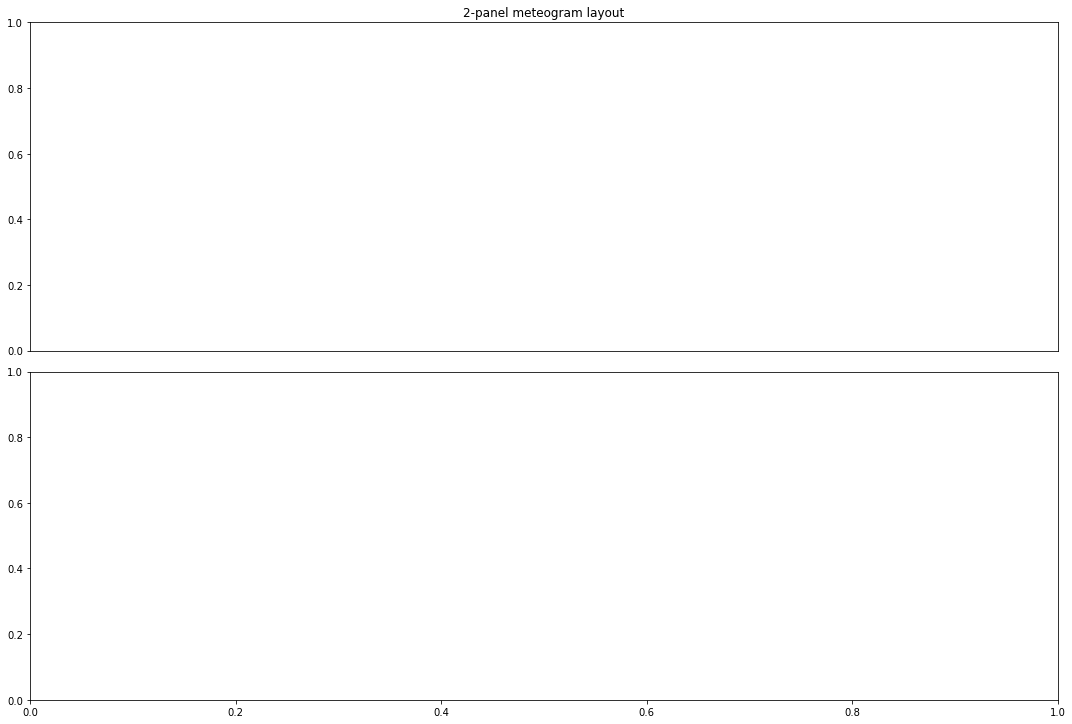

In [9]:
# Example of a subplot layout

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(211) # add the top subplot (2 rows, 1 column, subplot #1)
ax.get_xaxis().set_visible(False) # Since the x-axis will be shared, no need for tick labels on top x axis
ax2 = fig.add_subplot(212, sharex=ax) # add the bottom subplot
plt.tight_layout() # Remove unnecessary white space between panels
ax.set_title('2-panel meteogram layout') # Reference the first axis as this panel needs to be on top

## The Challenge
Task: Make a meteogram that displays as many of the weather variables from the csv as possible.  

The meteogram should have:
1. Descriptive plot title(s)
2. Axis labels
3. Grid lines
4. A legend
5. Formatted dates on the x-axis (hint: https://stackoverflow.com/questions/14946371/editing-the-date-formatting-of-x-axis-tick-labels-in-matplotlib)
6. Proper x and y ranges for the data

Optionally, you may want to add:
1. Multiple subplots
2. Wind barbs and cloud cover using metpy's station plot layout (https://unidata.github.io/MetPy/latest/examples/plots/Station_Plot.html)  
Hint: you can fix the location of the station plots with x and y values on the axes  

This is an open-ended project, so there is no "right" or "wrong" answer for what your meteogram should look like. Be creative, and check out the example meteogram (meteogram_example.png) if you need inspiration - or look at meteograms on your favorite weather website for ideas.

Good luck!